Please upload your WhatsApp chat export file (.txt)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving WhatsApp Chat with Chirag.txt to WhatsApp Chat with Chirag.txt

Chat Statistics:
Total Messages: 3351
Total Words: 11908
Media Shared: 0
Links Shared: 74
Unique Users: 2


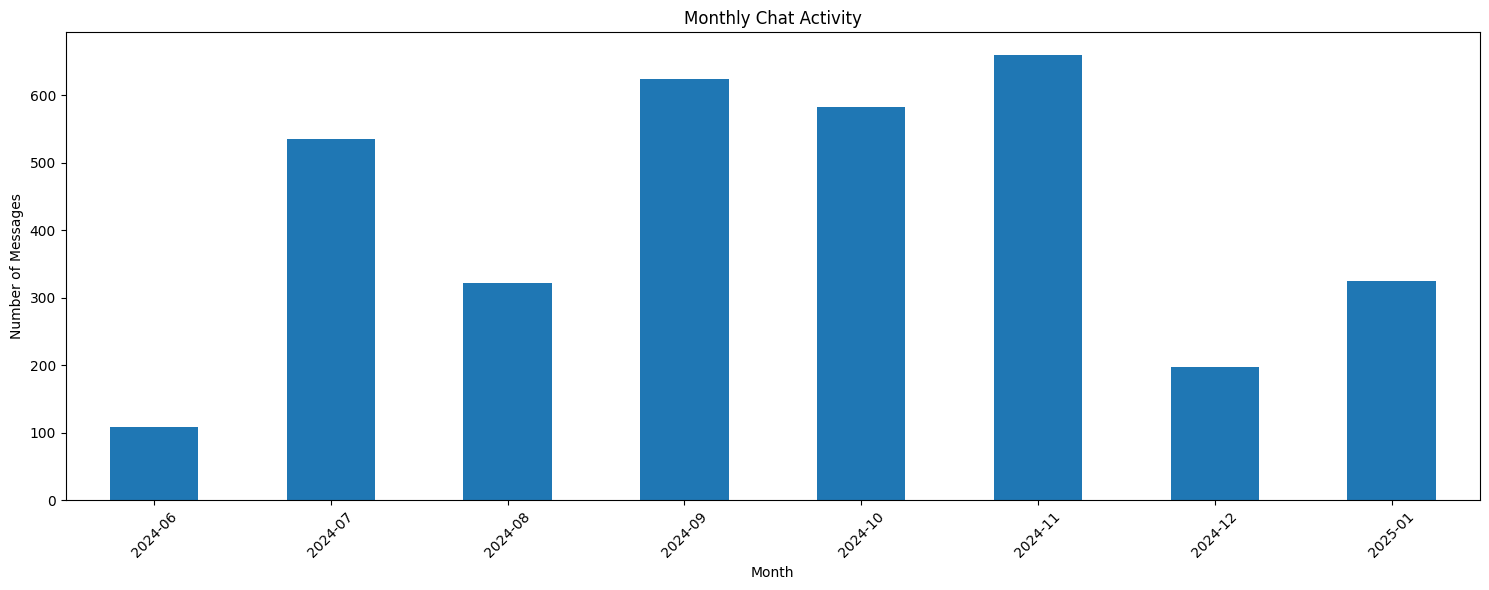

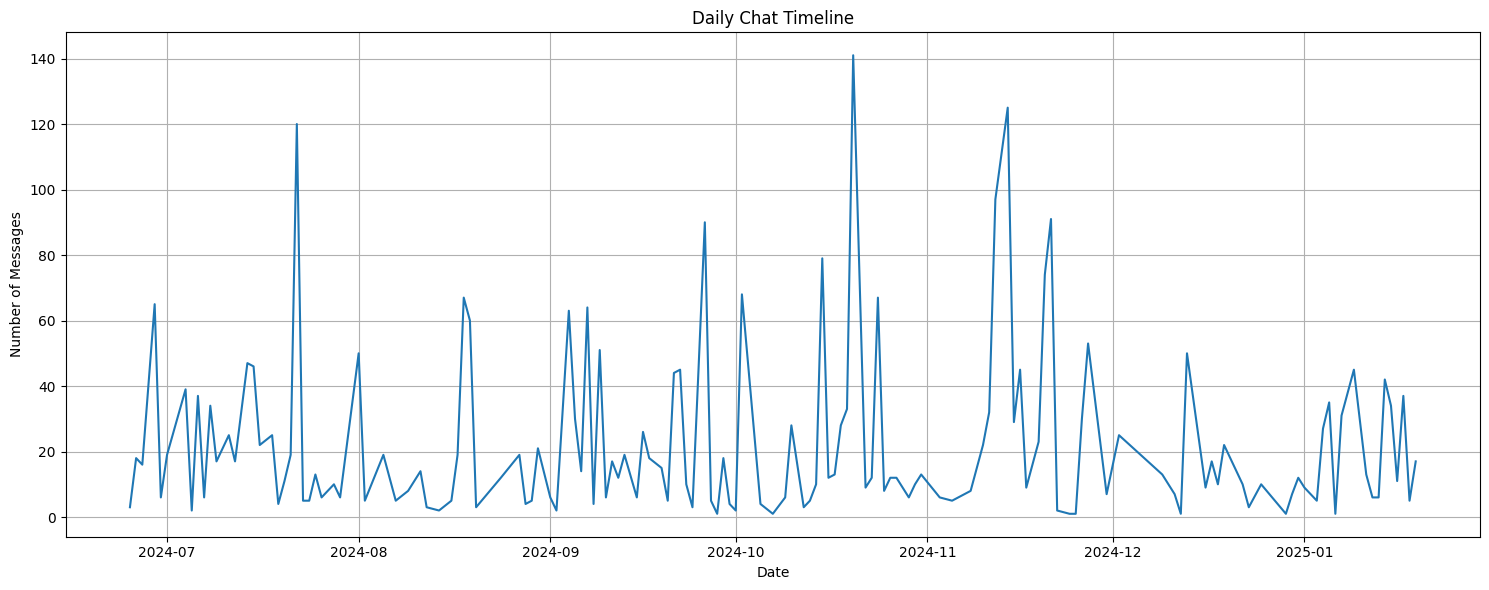

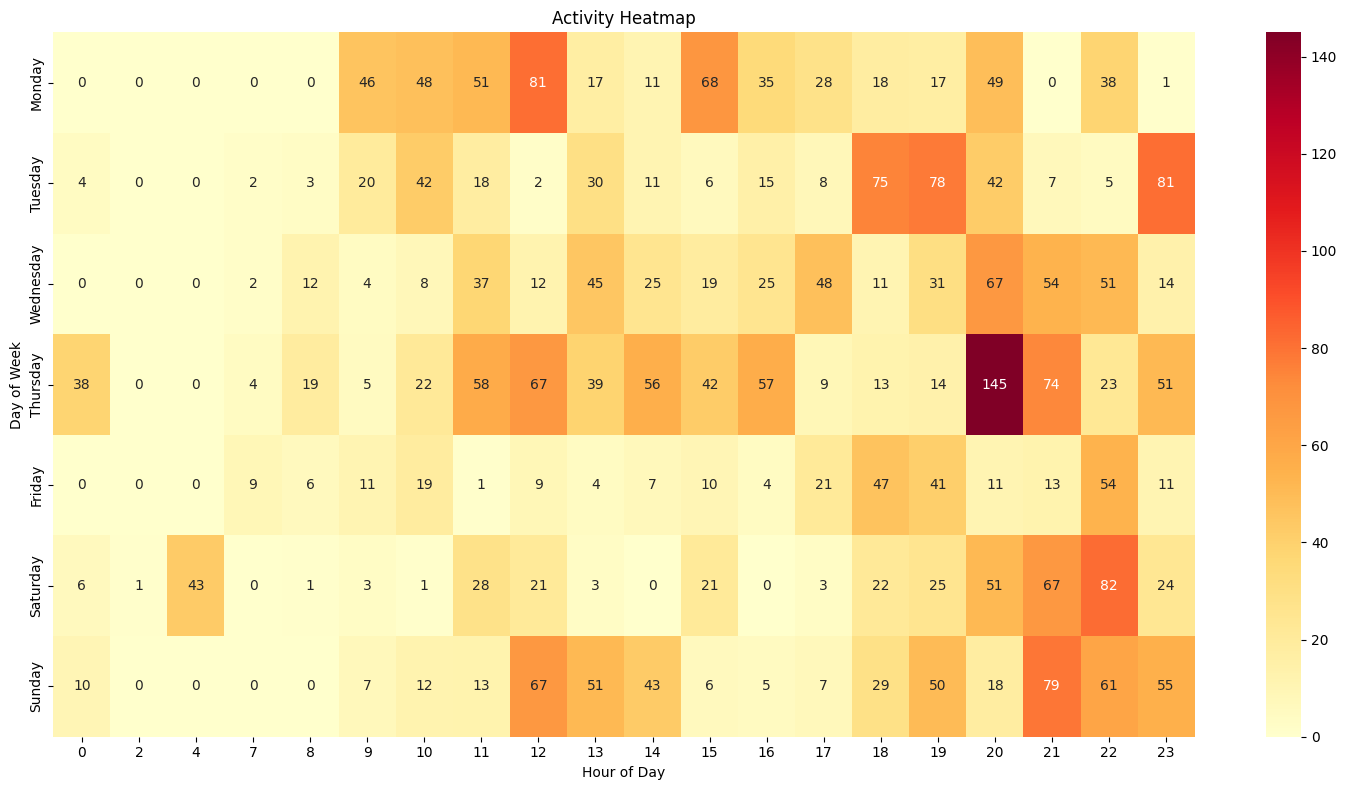

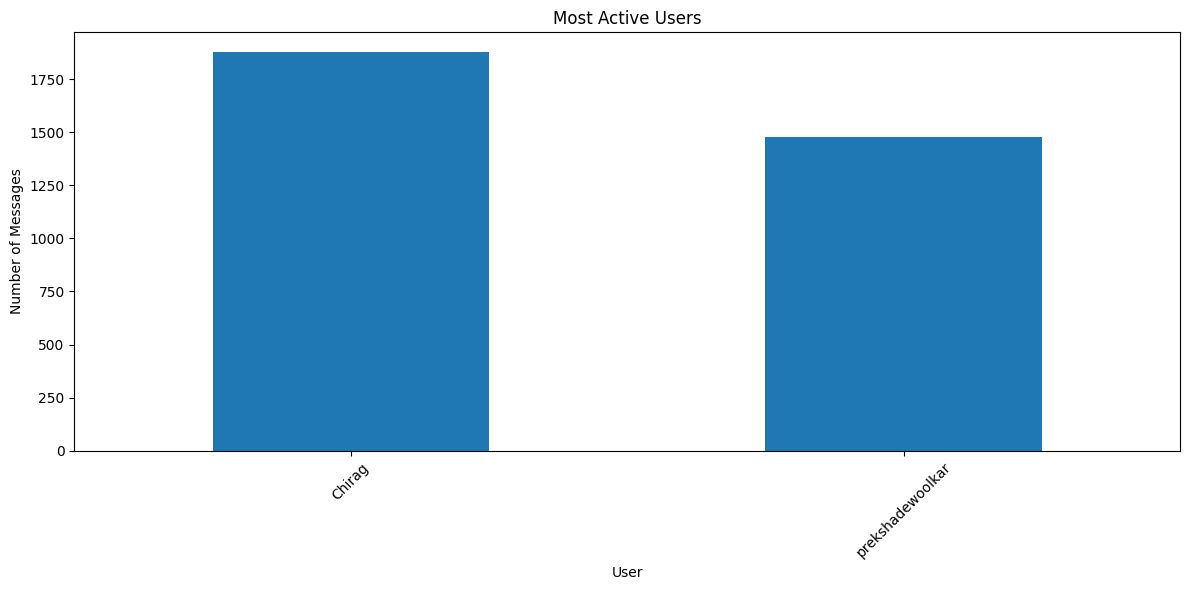

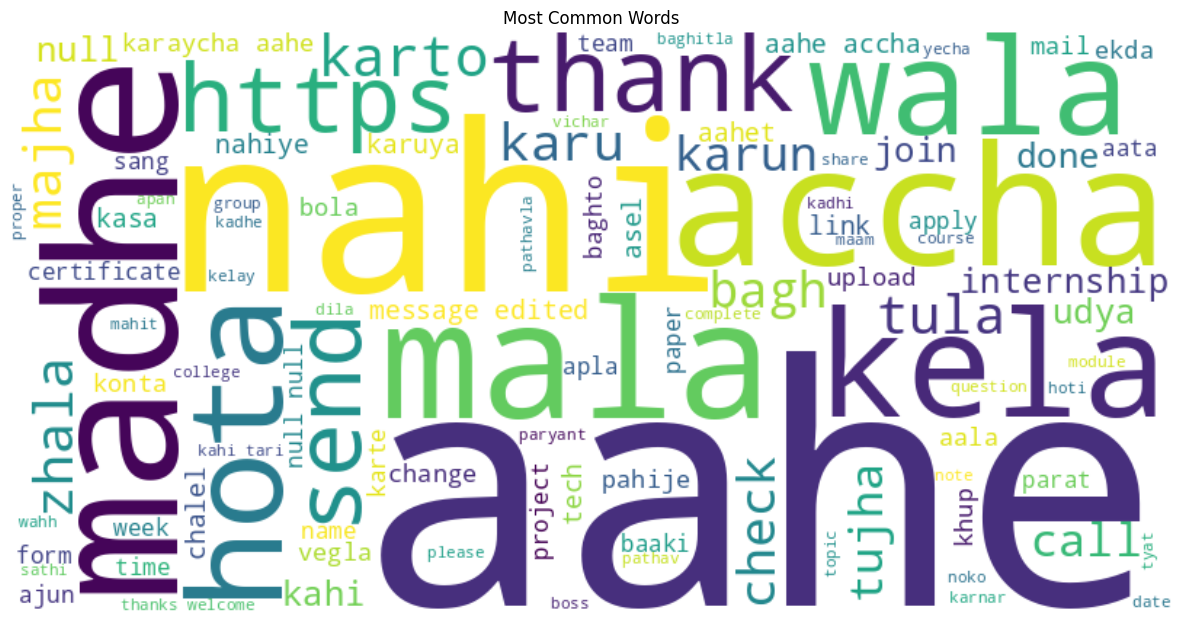


Top 10 Most Common Words:
aahe: 384
nahi: 133
accha: 95
madhe: 75
https: 73
mala: 69
kela: 65
null: 60
wala: 59
hota: 57


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud
from google.colab import files
import nltk
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

def upload_file():
    """Upload file using Colab's file upload widget"""
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    return file_name

def parse_chat(file_name):
    """Parse WhatsApp chat file and return a DataFrame"""
    # Regular expression pattern for WhatsApp chat lines
    pattern = r'(\d{1,2}/\d{1,2}/\d{2},\s\d{1,2}:\d{2}\s[AaPp][Mm])\s-\s([^:]+):\s(.+)'

    messages = []
    with open(file_name, 'r', encoding='utf-8') as file:
        for line in file:
            # Skip system messages
            if 'Messages and calls are end-to-end encrypted' in line or 'Media omitted' in line:
                continue

            match = re.match(pattern, line)
            if match:
                timestamp, sender, message = match.groups()
                try:
                    # Parse with 2-digit year format
                    timestamp = pd.to_datetime(timestamp, format='%d/%m/%y, %I:%M %p')
                except ValueError:
                    # Fallback to 4-digit year format if needed
                    try:
                        timestamp = pd.to_datetime(timestamp, format='%d/%m/%Y, %I:%M %p')
                    except ValueError:
                        continue  # Skip lines with unparseable dates

                messages.append({
                    'timestamp': timestamp,
                    'sender': sender.strip(),
                    'message': message.strip()
                })

    return pd.DataFrame(messages)

def get_general_stats(df):
    """Calculate general statistics about the chat"""
    total_messages = len(df)
    total_words = sum(len(str(msg).split()) for msg in df['message'])
    media_count = sum(df['message'].str.contains('Media omitted', case=False, na=False))
    links_count = sum(df['message'].str.contains('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                                                regex=True, na=False))
    unique_users = df['sender'].nunique()

    return {
        'Total Messages': total_messages,
        'Total Words': total_words,
        'Media Shared': media_count,
        'Links Shared': links_count,
        'Unique Users': unique_users
    }

def plot_monthly_activity(df):
    """Plot monthly message activity"""
    monthly = df.groupby(df['timestamp'].dt.to_period('M')).size()

    plt.figure(figsize=(15, 6))
    monthly.plot(kind='bar')
    plt.title('Monthly Chat Activity')
    plt.xlabel('Month')
    plt.ylabel('Number of Messages')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_daily_timeline(df):
    """Plot daily message timeline"""
    daily = df.groupby(df['timestamp'].dt.date).size()

    plt.figure(figsize=(15, 6))
    daily.plot(kind='line')
    plt.title('Daily Chat Timeline')
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_activity_heatmap(df):
    """Create activity heatmap by day and hour"""
    df['hour'] = df['timestamp'].dt.hour
    df['day_name'] = df['timestamp'].dt.day_name()

    pivot_table = df.pivot_table(
        index='day_name',
        columns='hour',
        values='message',
        aggfunc='count',
        fill_value=0
    )

    # Reorder days
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_table = pivot_table.reindex(days_order)

    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='g')
    plt.title('Activity Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.show()

def plot_active_users(df):
    """Plot most active users"""
    user_activity = df['sender'].value_counts().head(10)

    plt.figure(figsize=(12, 6))
    user_activity.plot(kind='bar')
    plt.title('Most Active Users')
    plt.xlabel('User')
    plt.ylabel('Number of Messages')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_common_words(df):
    """Analyze and plot most common words"""
    # Get stopwords for multiple languages
    stop_words = set(stopwords.words('english'))

    # Combine all messages
    all_words = ' '.join([str(msg) for msg in df['message']])

    # Clean and tokenize - exclude numbers and short words
    words = re.findall(r'\b[a-zA-Z]+\b', all_words.lower())
    words = [word for word in words if word not in stop_words and len(word) > 3]

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         min_font_size=10,
                         max_words=100).generate(' '.join(words))

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words')
    plt.show()

    # Print top 10 words
    word_freq = Counter(words).most_common(10)
    print("\nTop 10 Most Common Words:")
    for word, freq in word_freq:
        print(f"{word}: {freq}")

def main():
    """Main function to run the analysis"""
    print("Please upload your WhatsApp chat export file (.txt)")
    file_name = upload_file()

    # Parse chat and create DataFrame
    df = parse_chat(file_name)

    if len(df) == 0:
        print("No messages could be parsed from the file. Please check the file format.")
        return

    # Display general statistics
    stats = get_general_stats(df)
    print("\nChat Statistics:")
    for key, value in stats.items():
        print(f"{key}: {value}")

    # Create visualizations
    plot_monthly_activity(df)
    plot_daily_timeline(df)
    plot_activity_heatmap(df)
    plot_active_users(df)
    analyze_common_words(df)

if __name__ == "__main__":
    main()
